In [1]:
from jaxtyping import Float
from torch import Tensor
from torch.utils.tensorboard import SummaryWriter

import torch, wandb
import numpy as np
import matplotlib.pyplot as plt

from utils.model import L2Net
from utils.load import load_l2net_model

In [2]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
# torch.autograd.set_detect_anomaly(True)
writer = SummaryWriter(log_dir="./runs/l2_distance_experiment")

np.random.seed(42)
rng = torch.manual_seed(42)

In [3]:
torch.set_printoptions(threshold=10_000, precision=2, linewidth=160, sci_mode=False)

In [ ]:
cfg = dict(
    NUM_SAMPLES = 100000,
    NUM_EPOCHS = 100,
    VECTOR_DIM = 64,
    MIN_VAL = -6.,
    MAX_VAL = 6.,
    TIME_STEPS = 21,
    JEFFRESS_COMPRESSION = 1,
    BATCH_SIZE = 512,
    LR = 3e-2,
    EVAL_MODE = False,
)

In [5]:
NUM_SAMPLES = int(cfg["NUM_SAMPLES"])  # 총 1000 개의 샘플 생성
NUM_EPOCHS = int(cfg["NUM_EPOCHS"])
VECTOR_DIM = int(cfg["VECTOR_DIM"])      # 각 벡터는 3차원
MIN_VAL = cfg["MIN_VAL"]
MAX_VAL = cfg["MAX_VAL"]
TIME_STEPS = int(cfg["TIME_STEPS"])  # 각 레이어 당 17 타임스텝
JEFFRESS_COMPRESSION = int(cfg["JEFFRESS_COMPRESSION"])
BATCH_SIZE = int(cfg["BATCH_SIZE"])
LR = float(cfg["LR"])
EVAL_MODE = bool(cfg["EVAL_MODE"])

In [6]:
model = L2Net(TIME_STEPS,
              VECTOR_DIM,
              jeffress_radius=TIME_STEPS-1,
              jeffress_compression=JEFFRESS_COMPRESSION,
              temporal_min=MIN_VAL,
              temporal_max=MAX_VAL,
              accelerated=True,).to(device)
model

L2Net(
  (jeffress_model): Sequential(
    (0): TimePadding(steps=21)
    (1): JeffressFilter(
      in_features=2, out_features=40
      (filter): LIF_Filter(
        step_mode=m, backend=torch, lif_tau=9.999999999999952, filter_tau=1.0000000000000038, step_mode=m
        (synapse_filter): SynapseFilter(tau=1.58197670686933, learnable=False, step_mode=m)
        (lif_filter): SynapseFilter(tau=10.508331944775, learnable=False, step_mode=m)
      )
    )
    (2): SpikeAmplifier(
      (model): SpikeAmplifierNetwork(
        (neuron): IFNode(
          v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch
          (surrogate_function): ATan(alpha=2.0, spiking=True)
        )
      )
    )
    (3): TimeCrop(steps=21)
    (4): SynapseFilter(tau=2.0, learnable=True, step_mode=m)
    (5): Linear(in_features=40, out_features=1, bias=False)
  )
  (out_neuron): LIFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch, tau=20.0
    (surro

In [7]:
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from utils.datasets import generate_l2_square_dataset, encode_temporal_np

X_data, y_data = generate_l2_square_dataset(NUM_SAMPLES, VECTOR_DIM, low=MIN_VAL, high=MAX_VAL, normalize=True)  # X_data: N 2 D, y_data: N
X_data_temporal = torch.stack([torch.FloatTensor(encode_temporal_np(X_data[:,0,:], TIME_STEPS, 0, min_val=MIN_VAL, max_val=MAX_VAL)),
                      torch.FloatTensor(encode_temporal_np(X_data[:,1,:], TIME_STEPS, 0, min_val=MIN_VAL, max_val=MAX_VAL))],
                     dim=2) # T N 2D
y_data = torch.FloatTensor(y_data) # N D
dataset = torch.utils.data.TensorDataset(X_data_temporal.transpose(1, 0), y_data, torch.tensor(X_data))  # T N 2D -> N T 2D
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
    )
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
loss = torch.tensor(float("inf"))

pbar = tqdm(range(NUM_EPOCHS))
pred_hist, target_hist, err_hist = [], [], []
train_step = 0
eval_step = 0
substep = 0
eval_substep = 0
if not EVAL_MODE:
    with wandb.init(project="DelayedTemporal",
                    config=cfg) as run:
        run.define_metric("train/*", step_metric="train_step")
        run.define_metric("delay/*", step_metric="train_step")
        run.define_metric("SDC/*", step_metric="train_step")
        run.define_metric("Neuron/*", step_metric="substep")
        run.define_metric("eval/*", step_metric="eval_step")
        run.define_metric("eval_sub/*", step_metric="eval_substep")
        for epoch in pbar:
            model.train()
            for i, batch in enumerate(tqdm(train_loader, leave=False)):
                inputs:Float[Tensor, "N T 2 D"]; targets:Float[Tensor, "N D"]
                inputs, targets, input_raw = batch
                inputs = inputs.to(device); targets = targets.to(device); input_raw = input_raw.to(device)
                out = model(inputs.transpose(1, 0)) # N T 2 D -> T N 2 D -> model -> T N 1
                pred = out
                loss = criterion(pred, targets)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                pbar.set_postfix({"loss": loss.item(), "scale":(out.max()-out.min()).item(), "lr": scheduler.get_last_lr()[0]})
                if i % 10 == 0:
                    run.log({
                        "train_step": (train_step := train_step + 1),
                        "train/loss": loss.item(),
                        "train/err":(pred - targets).abs().mean().item(),
                    # }|{
                    #         f"SDC/rate_{i}": torch.stack(model.stats['jeffress_model.2.neuron'], dim=0).mean(dim=(0,1,2))[i] for i in range(2*TIME_STEPS - 1)
                            }
                    )
                    # for t in range(2*TIME_STEPS):
                    #     run.log({
                    #         "substep": (substep := substep + 1),
                    #     }
                    #             |{
                    #         f"Neuron/I_{j}": model.jeffress_model[2].i_seq[t][0,0,j] for j in range(2*TIME_STEPS - 1)
                    #         }
                    #             |{
                    #         f"Neuron/V_{j}": model.jeffress_model[2].v_seq[t][0,0,j] for j in range(2*TIME_STEPS - 1)
                    #         })
            scheduler.step()
            
            with torch.no_grad():
                model.eval()
                for batch in tqdm(test_loader, leave=False):
                    inputs, targets, input_raw = batch
                    inputs = inputs.to(device); targets = targets.to(device); input_raw = input_raw.to(device)
                    out = model(inputs.transpose(1, 0)) # NT(2D)->TN(2D)->model->N
                    pred = out
                    loss = criterion(pred, targets)
                    pred_hist.extend(pred.squeeze().tolist())
                    target_hist.extend(targets.squeeze().tolist())
                    err_hist.extend(torch.abs(pred.squeeze() - targets.squeeze()).tolist())
                    pbar.set_postfix({"loss": loss.item(), "pred": pred_hist[-1], "target": target_hist[-1]})
                    
                    run.log({"eval_step": (eval_step := eval_step + 1),
                            "eval/loss": loss.item()})
                    for n in range(pred.shape[0]):
                        run.log({"eval_substep": (eval_substep := eval_substep + 1),
                            "eval_sub/err":  (pred - targets).abs()[n].item()})
else:
    hex = "fa73b386e47111f0a1fe0242ac11000f"
    models, cfg = load_l2net_model(hex, parallel=False)
    model = models[torch.device(0)].to(device)
    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs, targets, input_raw = batch
            inputs = inputs.to(device); targets = targets.to(device); input_raw = input_raw.to(device)
            out = model(inputs.transpose(1, 0)) # NT(2D)->TN(2D)->model->N
            pred = out
            loss = criterion(pred, targets)
            pred_hist.extend(pred.squeeze().tolist())
            target_hist.extend(targets.squeeze().tolist())
            err_hist.extend(torch.abs(pred.squeeze() - targets.squeeze()).tolist())
    print(f"Test MSE Loss: {loss.item():.6f}, MAE: {np.mean(err_hist):.6f}")

  0%|          | 0/100 [00:00<?, ?it/s]

L2Net loaded with following configuration:
{'NUM_SAMPLES': 100000, 'NUM_EPOCHS': 100, 'VECTOR_DIM': 64, 'MIN_VAL': -4.0, 'MAX_VAL': 4.0, 'TIME_STEPS': 21, 'JEFFRESS_COMPRESSION': 1, 'BATCH_SIZE': 512, 'LR': 0.03, 'EVAL_MODE': False}


  0%|          | 0/40 [00:00<?, ?it/s]

W0102 13:47:41.728000 2644835 torch/_logging/_internal.py:1199] [0/0] Profiler function <class 'torch.autograd.profiler.record_function'> will be ignored


Test MSE Loss: 0.009456, MAE: 0.096520


In [8]:
if not EVAL_MODE:
    from uuid import uuid1
    from json import load, dump
    from pathlib import Path

    save_id = uuid1().hex
    save_dir = Path(f"models/{save_id}")

    if not save_dir.exists():
        save_dir.mkdir(parents=True, exist_ok=True)

    with open("models/contents.json", "r", encoding="utf-8") as f:
        contents = load(f)

    contents |= ({save_id: {
        "model": model.__class__.__name__,
        "final_loss": loss.item(),
        "final_mae": np.mean(err_hist)} | cfg})

    with open("models/contents.json", "w", encoding="utf-8") as f:
        dump(contents, f, indent=4)

    torch.save(model.state_dict(), save_dir / "model.pt")
    torch.save(cfg, save_dir / "model.cfg")

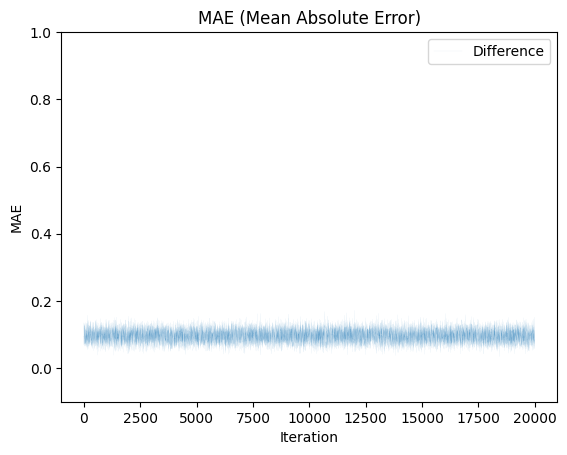

In [9]:
plt.title("MAE (Mean Absolute Error)")
plt.plot(err_hist, linewidth=0.025, label="Difference")
plt.ylim(-.1, 1)
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.legend()

In [10]:
# y_data

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

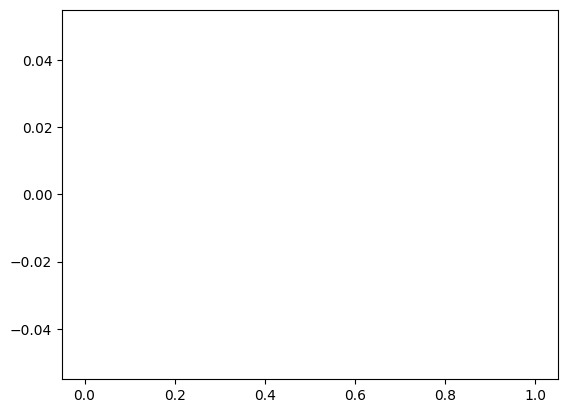

In [11]:
plt.hist(err_hist[100000:])